<a href="https://colab.research.google.com/github/sofiadutta/PyTorch-Experiments/blob/master/Image-Classification-using-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn #n
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from tqdm.autonotebook import tqdm

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml

#### **1. Try different numbers of layers, and hiddent state sizes, to increase the accuracy of your MNIST classifier. What network seems to perform best? Are there any trends you notice in what works, or is there no relationship? Don't train for more than 10 epochs.**


Shape of X :  (70000, 784)
Shape of y :  (70000,)
torch.Size([784])
tensor(5)


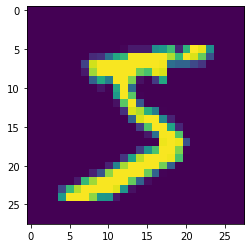

In [0]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print('Shape of X : ',X.shape)
print('Shape of y : ',y.shape)


class SimpleDataset(Dataset):
        
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
        
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(int(self.y[index]), dtype=torch.long)
        #return self.X[index,:], int(self.y[index])

    def __len__(self):
        return self.X.shape[0]

dataset = SimpleDataset(X, y)

example, label = dataset[0]
print(example.shape) #Will return 784
print(label)

plt.imshow(example.reshape((28,28)))

In [0]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset)-train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, test_size))

print("{} examples for training and {} for testing".format(len(train_dataset), len(test_dataset)))

training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset, shuffle=False)

56000 examples for training and 14000 for testing


[Data Reshape Link](https://discuss.pytorch.org/t/runtimeerror-size-mismatch-m1-3584-x-28-m2-784-x-128-at-pytorch-aten-src-th-generic-thtensormath-cpp-940/34804)

In [0]:
def train_simple_network_with_input_reshape(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                                            epochs=50, device="cpu", checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    Here used the method provided in lecture only added code to flatten the inputs before passing to linear model
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #flatten the input to fit in linear model
            y_hat = model(inputs.view(inputs.size(0),-1)) #this just computed f_Θ(x(i))#pass in a flattened view of inputs

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * inputs.size(0)
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)

                #flatten the input to fit in linear model
                y_hat = model(inputs.view(inputs.size(0),-1)) #pass in a flattened view of inputs
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * inputs.size(0)

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)




**Creation of two models with different numbers of layers, and hiddent state sizes, to increase the accuracy of your MNIST classifier.**

In [0]:
model1 = nn.Sequential(
    nn.Linear(784,  784),
    nn.Tanh(),
    nn.Linear(784,  120),
    nn.Tanh(),
    nn.Linear(120, 10),
)

loss_func = nn.CrossEntropyLoss()
results_pd1 = train_simple_network_with_input_reshape(model1, loss_func, training_loader, epochs=10, val_loader=testing_loader,
                                                      checkpoint_file='model1.pt', score_funcs={'Acc':accuracy_score})

**Checking Accuracy of the first model**

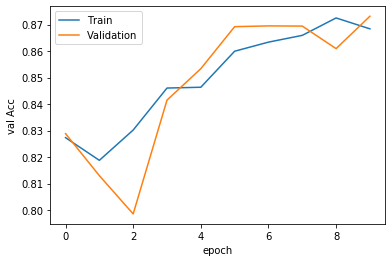

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd1, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd1, label='Validation')

In [0]:
model2 = nn.Sequential(
    nn.Linear(784,  784),
    nn.Tanh(),
    nn.Linear(784,  120),
    nn.Tanh(),
    nn.Linear(120,  84),
    nn.Tanh(),
    nn.Linear(84, 10),
)

loss_func = nn.CrossEntropyLoss()
results_pd2 = train_simple_network_with_input_reshape(model2, loss_func, training_loader, epochs=10, val_loader=testing_loader,
                                                      checkpoint_file='model2.pt', score_funcs={'Acc':accuracy_score})

**Checking Accuracy of the second model**

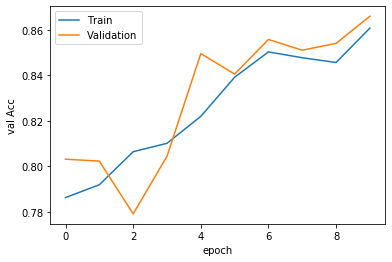

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd2, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd2, label='Validation')

### **Creating MNIST training loader and testing loader using torchvision.datasets.MNIST**

In [0]:
transform = transforms.ToTensor()
mnist_training_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
print('mnist_train_data : \n',mnist_training_data)
mnist_testing_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
print('mnist_testing_data : \n',mnist_testing_data)


Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw



Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw



Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw



Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw
Processing...
Done!
mnist_train_data : 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()
mnist_testing_data : 
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()


Shape: torch.Size([1, 28, 28]) 
Label: 5


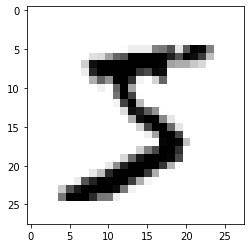

In [0]:
image, label = mnist_training_data[0]
print('Shape:', image.shape, '\nLabel:', label)

plt.imshow(mnist_training_data[0][0].reshape((28,28)), cmap="gist_yarg")

In [0]:
mnist_training_loader = DataLoader(mnist_training_data, shuffle=True)

mnist_testing_loader = DataLoader(mnist_testing_data, shuffle=False)

**Creation of two models with different numbers of layers, and hiddent state sizes, to increase the accuracy of your MNIST classifier.**

In [0]:
model_1 = nn.Sequential(
    nn.Linear(784,  784),
    nn.Tanh(),
    nn.Linear(784,  84),
    nn.Tanh(),
    nn.Linear(84, 10),
)

loss_func = nn.CrossEntropyLoss()
results_pd_1 = train_simple_network_with_input_reshape(model_1, loss_func, mnist_training_loader, epochs=10, val_loader=mnist_testing_loader,
                                                       checkpoint_file='model_1.pt', score_funcs={'Acc':accuracy_score})

**Checking Accuracy of the first model**

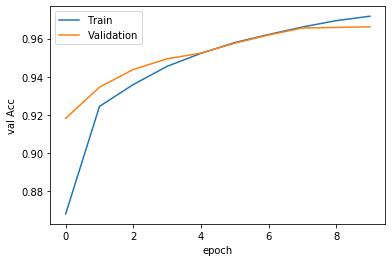

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd_1, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd_1, label='Validation')

In [0]:
model_2 = nn.Sequential(
    nn.Linear(784,  784),
    nn.Tanh(),
    nn.Linear(784,  120),
    nn.Tanh(),
    nn.Linear(120,  84),
    nn.Tanh(),
    nn.Linear(84, 10),
)

results_pd_2 = train_simple_network_with_input_reshape(model_2, loss_func, mnist_training_loader, epochs=10, val_loader=mnist_testing_loader,
                                                      checkpoint_file='model_2.pt', score_funcs={'Acc':accuracy_score})

**Checking Accuracy of the second model**

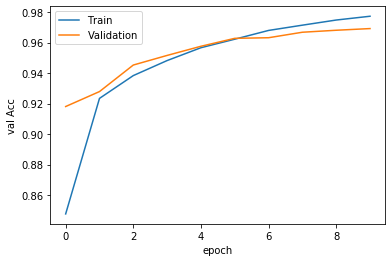

In [0]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd_2, label='Train')
sns.lineplot(x='epoch', y='val Acc', data=results_pd_2, label='Validation')

* model_2,the second Model with more non-linear functions or activation functions tanh() performs better.
* Adding any number of hidden layers will be equivalent to having used just one linear layer, hence to get any kind of benefit in accuray,I need to introduce some kind of non-linearity between every step which is achieved using torch.nn.tanh(), the hyperbolic tangent functions.

####**2. Take your best model and use the checkpoint option to save your models, and then load it back in and apply it to some of the MNIST test set. (Its OK to be using google on how to do that!)**

[Saving And Loading Models Link](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

**Saving best model using the checkpoint option**

In [0]:
torch.save({'model_state_dict': model_2.state_dict()}, 'mnist_best_model.pt')

**Loading it back**

In [0]:
model_new = nn.Sequential(
    nn.Linear(784,  784),
    nn.Tanh(),
    nn.Linear(784,  120),
    nn.Tanh(),
    nn.Linear(120,  84),
    nn.Tanh(),
    nn.Linear(84, 10),
)
device = torch.device("cpu")
checkpoint_dict = torch.load('mnist_best_model.pt', map_location=device)


model_new.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

**Applying it to the MNIST test set**

[Link](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [0]:
# Extract the data all at once, not in batches
mnist_test_load_all = DataLoader(mnist_testing_data, batch_size=10000, shuffle=False) #Prof: batch size of 10k! You should probably never use that big! Keep it 32 <= b <= 1024 is a more normal range!

In [0]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in mnist_test_load_all:
        y_val = model_new(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(mnist_testing_data)} = {correct.item()*100/(len(mnist_testing_data)):7.3f}%')

Test accuracy: 9692/10000 =  96.920%


####**3.Use PyTorch to load the CIFAR10 dataset (its OK if you need to google / read the docs for this!). Try to build a network that does well on this dataset. Do you get better/worse accuracy? Why do you think?**

**Loading the CIFAR10 dataset using PyTorch**

In [0]:
transform = transforms.ToTensor()

cifar10_training_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
cifar10_testing_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)
print('cifar10_training_data : \n',cifar10_training_data)
print('cifar10_testing_data : \n',cifar10_testing_data)


Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified
cifar10_training_data : 
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()
cifar10_testing_data : 
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [0]:
torch.manual_seed(101)  # for reproducible results

cifar10_training_loader = DataLoader(cifar10_training_data, shuffle=True)
cifar10_testing_loader = DataLoader(cifar10_testing_data, shuffle=False)

In [0]:
cifar10_training_data[0][0].shape #Prof: leave notes about why you are printing these out! Helps future you when working on something more complex that needs to be maintained

torch.Size([3, 32, 32])

In [0]:
cifar10_training_data[0][0].view(-1).size()

torch.Size([3072])

**Linear model creation for CIFAR10 Dataset**

In [0]:
D = 32*32*3 #32 * 32 images 
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 10

model_linear1 = nn.Sequential( 
  nn.Linear(D, 32*3*3),
  nn.Tanh(),
  nn.Linear(32*3*3, classes),
)

In [0]:
loss_func = nn.CrossEntropyLoss()
fc_results1 = train_simple_network_with_input_reshape(model_linear1, loss_func, cifar10_training_loader, val_loader=cifar10_testing_loader, 
                                                     score_funcs={'Accuracy': accuracy_score}, epochs=10)

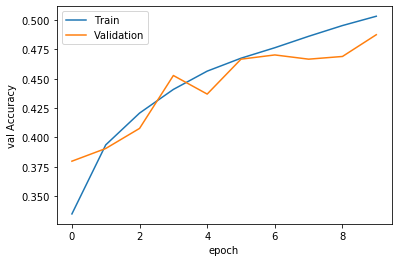

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=fc_results1, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results1, label='Validation')

[StackOverflow Link1](https://stackoverflow.com/questions/55278566/runtimeerror-expected-object-of-backend-cuda-but-got-backend-cpu-for-argument)
[StackOverflow Link2](https://stackoverflow.com/questions/53900910/typeerror-can-t-convert-cuda-tensor-to-numpy-use-tensor-cpu-to-copy-the-tens)

In [0]:
cifar10_testing_load_all = DataLoader(cifar10_testing_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in cifar10_testing_load_all:
        y_val = model_linear1(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(cifar10_testing_data)} = {correct.item()*100/(len(cifar10_testing_data)):7.3f}%')

Test accuracy: 4874/10000 =  48.740%


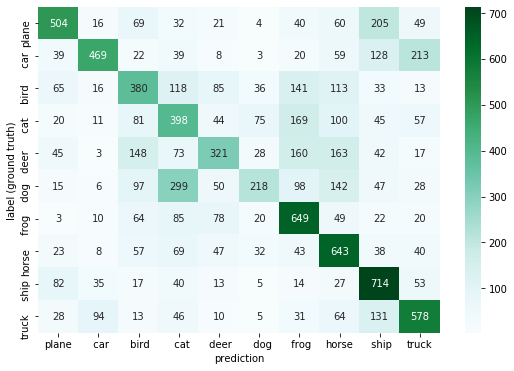

In [0]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show() #Prof: above and beyond ont he confusion matrix! If you do something like this, you should look at the errors. What does it tell you about the nature of the mistakes? eg., cat/dog and truck/car are confused more than a bird & truck!

**Linear model creation for CIFAR10 Dataset**
* Used Flatten Class to reshape the data

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


#This is defining a simple PyTorch laye to convert a tensor from (N, C, W, H) 
#to one of shape (N, D=C*W*H). Despite being useful, the pyTorch folks refuse to
#add one. We will use it later!
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [0]:
D = 32*32*3 #32 * 32 images 
#Number of channels in the input
C = 3
#Number of classes
classes = 10

model_linear2 = nn.Sequential(
  Flatten(), 
  nn.Linear(D, 32*3*3),
  nn.Tanh(),
  nn.Linear(32*3*3, classes),
)

In [0]:
def train_simple_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * inputs.size(0)
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * inputs.size(0)

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)




In [0]:
loss_func = nn.CrossEntropyLoss()
fc_results2 = train_simple_network(model_linear2, loss_func, cifar10_training_loader, val_loader=cifar10_testing_loader, 
                                  score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

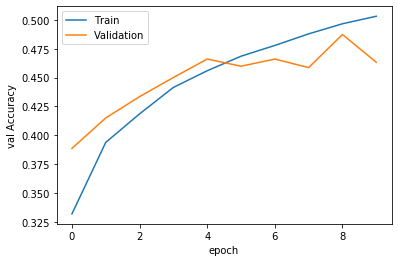

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=fc_results2, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=fc_results2, label='Validation')

[StackOverflow Link1](https://stackoverflow.com/questions/55278566/runtimeerror-expected-object-of-backend-cuda-but-got-backend-cpu-for-argument)
[StackOverflow Link2](https://stackoverflow.com/questions/53900910/typeerror-can-t-convert-cuda-tensor-to-numpy-use-tensor-cpu-to-copy-the-tens)

In [0]:
cifar10_testing_load_all = DataLoader(cifar10_testing_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in cifar10_testing_load_all:
        X_test = X_test.to(device)  
        y_test = y_test.to(device)
        y_val = model_linear2(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(cifar10_testing_data)} = {correct.item()*100/(len(cifar10_testing_data)):7.3f}%')

Test accuracy: 4633/10000 =  46.330%


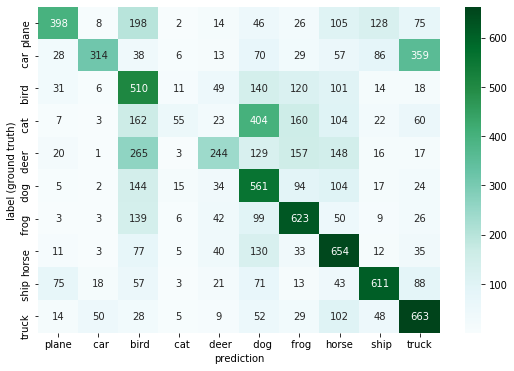

In [0]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

* Accuracy is low.Accuracy is worse. #Prof: this needs more elaboration!
* As the Model has less non-linear functions or activation functions tanh().Also it can not take the advantage of spatial relationship in the data and unable to learn well the feature in the data on its own.

#### **4.Next lecture we will learn about Convolutional Networks. Once we learn about them, re-do problem 3 (using CIFAR10) but use a Convolutional network. Did it perform better or worse? Why do you think?**

**Convolutional network for CIFAR10 Dataset**

In [0]:
#Number of input
D = 32*32 #32 * 32 images 
#Number of channels in the input
C = 3
#Number of classes
classes = 10

model_cnn_pool = nn.Sequential(
  nn.Conv2d(C, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  nn.Conv2d(32, 32, (3,3), padding=1), 
  nn.MaxPool2d((2,2)),
  nn.Tanh(),
  Flatten(),  
  nn.Linear(32*D//(4**2), classes),
)

In [0]:
cnn_results_with_pool = train_simple_network(model_cnn_pool, loss_func, cifar10_training_loader, val_loader=cifar10_testing_loader, 
                                             score_funcs={'Accuracy': accuracy_score}, device=device, epochs=10)

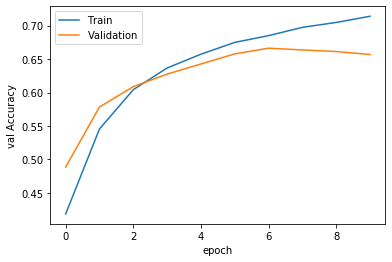

In [0]:
sns.lineplot(x='epoch', y='train Accuracy', data=cnn_results_with_pool, label='Train')
sns.lineplot(x='epoch', y='val Accuracy', data=cnn_results_with_pool, label='Validation')

In [0]:
cifar10_testing_load_all = DataLoader(cifar10_testing_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in cifar10_testing_load_all:
        X_test = X_test.to(device)  
        y_test = y_test.to(device)
        y_val = model_cnn_pool(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(cifar10_testing_data)} = {correct.item()*100/(len(cifar10_testing_data)):7.3f}%')

Test accuracy: 6569/10000 =  65.690%


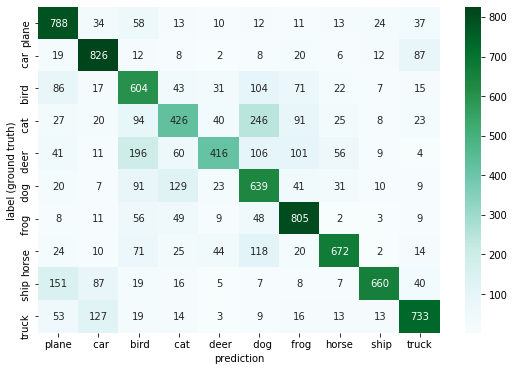

In [0]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

* Accuracy is better while using convolutional network for CIFAR10 dataset.
#Prof: below paragraph is a better example of explenation! Try writing more explanitory notes like this. 
* Because I have given CNN information about the problem (convolutions) via the structure of the domain (data are images).
To take advantage of spatial relationship, I define some operations that are spatial in nature, that is convolution. Convolution takes an input image, and a filter.
This let the neural network figure out which filters it should learn on its own, I just give it the (very strong) prior that it should be using this spatial operation.Inserted non-linearities between the layers in order to increase the representational power.Added Pooling layer to help solve problem, that aren't fully exploiting the spatial nature of the data. 

# Grade: 100/100

Good first assignment! Your code is good, you could improve it by defining a function to build your network, and using a for loop to test more optoins. I think the biggest item for you to work on is the notes and text you leave. The last paragraph was a good one. In the future, try and aim for one paragaph like that in each section to explain the results. 